# 機械学習をPythonで実践する-6　　～ 分類器の精度指標 ～

In [204]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import product
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, label_binarize
# import statsmodels.api as sma
from sklearn.model_selection import train_test_split ,LeaveOneOut, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, log_loss, confusion_matrix,ConfusionMatrixDisplay, \
accuracy_score, precision_score, recall_score,precision_recall_curve,f1_score,roc_curve,auc
from scipy.stats import hmean
# from sklearn.pipeline import Pipeline
# from sklearn.neighbors import KNeighborsRegressor


%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## ○ 混同行列
* sklearn.metrics.confusion_matrixクラスで混同行列インスタンスを生成
    * confusin_matrix(y_true, y_pred)
    * 戻り値はNumpy Array


* 混同行列(Confusion Matrix)をヒートマップで綺麗に表示する方法。
    * sklearn.metrics.ConfusionMatrixDisplay
    * ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    * confusion_matrix引数にはconfusion_matrix()の戻り値を入れる
    1. インスタンス生成
    2. .plot()メソッドで描画

In [61]:
# データ読み込み
df = sns.load_dataset('iris')
y_col = 'species'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# モデル学習。3クラスだが、デフォルトでmulti=autoなので何も指定しなくても多クラス分類してくれる。
model = LogisticRegression(penalty='none')
model.fit(X_train,y_train)

# 予測
y_pred = model.predict(X_test)

In [62]:
y_pred

array(['virginica', 'versicolor', 'setosa', 'virginica', 'setosa',
       'virginica', 'setosa', 'versicolor', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'versicolor',
       'versicolor', 'setosa', 'versicolor', 'versicolor', 'setosa',
       'setosa', 'virginica', 'versicolor', 'setosa', 'setosa',
       'versicolor', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'setosa', 'virginica', 'versicolor', 'setosa', 'virginica',
       'virginica', 'versicolor', 'setosa', 'virginica', 'versicolor',
       'versicolor', 'virginica', 'setosa', 'virginica', 'setosa',
       'setosa'], dtype=object)

In [63]:
# 混同行列
cm = confusion_matrix(y_test, y_pred)
cm

array([[16,  0,  0],
       [ 0, 17,  1],
       [ 0,  1, 10]])

In [64]:
# クラスの順番を表示
model.classes_

array(['setosa', 'versicolor', 'virginica'], dtype=object)

混同行列は縦に正解ラベルのsetosa,versicolor,virginica、横に予測値のsetosa,versicolor,virginicaとなっている。  
１行２列目の1は正解はversicolorなのに予測値がvirginicaであるという不正解が1件あったことを表す。

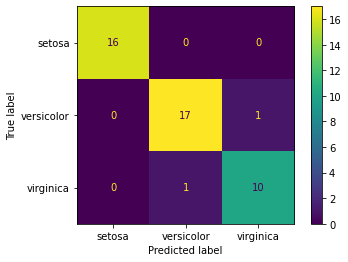

In [65]:
# 視覚的にわかりやすく混同行列を表示する。
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

対角成分はそれぞれのクラス（列ごと）におけるTPを表す。  

## ○ Accuracy(正解率)
* sklearn.metrics.accuracy_score
    * accuracy_score(y_true, y_pred)

In [66]:
# irisデータの正解率。
accuracy_score(y_test, y_pred)

0.9555555555555556

In [195]:
# 分子は混同行列の対角成分(TP)の和になる。
(16+17+10)/(len(y_pred))

0.9555555555555556

## ○ Precision(適合率)
* sklearn.metrics.precision_score
    * precision_score(y_true, y_pred)

In [68]:
# ２値分類に使うことが多いので、サンプルデータを作る
y_true_tmp = [1, 1, 0, 1, 0, 0, 1, 1]
y_pred_tmp = [1, 1, 1, 0, 0, 1, 0, 1]

# Precisionを計算
precision_score(y_true_tmp, y_pred_tmp)

0.6

陽性(=1)と分類した中で実際に陽性である割合は60%とわかる。

## ○ Recall(再現率)
* sklearn.metrics.recall_score
    * recall_score(y_true, y_pred)

In [69]:
# recallを計算
recall_score(y_true_tmp, y_pred_tmp)

0.6

## ○ Specificity
sklearnには実装されていないが、recall_scoreを使って簡単に計算可能。  
→データの陽性と陰性を逆にしてRecallを求めればOK（元々陰性の値が陽性になるので、RecallでSpecificityに相当する値が算出できる）

In [70]:
y_true_tmp

[1, 1, 0, 1, 0, 0, 1, 1]

In [71]:
y_pred_tmp

[1, 1, 1, 0, 0, 1, 0, 1]

In [72]:
# numpy配列化して1との否定をとることで、陰性と陽性を逆にする
np.array(y_true_tmp)!=1

array([False, False,  True, False,  True,  True, False, False])

In [73]:
# 評価指標の各メソッドはbooleanの配列を入れることもできる。（Python的には0,1はbooleanと互換性があるため）
recall_score(np.array(y_true_tmp)!=1, np.array(y_pred_tmp)!=1)

0.3333333333333333

## ○ 多クラス評価におけるPrecision
* sklearn.metrics.precision_score
    * precision_score(y_true, y_pred, average)
    * average引数に’macro’, ‘micro’を渡す
    * Noneを渡すとクラス別に指標を計算しlistで返す
    * 他の指標(recall_score, accuracy_score, etc.)も同様

In [74]:
# クラスごとのPrecisionを算出
print(f'average=Noneのとき：\n{model.classes_}\n{precision_score(y_test, y_pred, average=None)}')

# macro平均を算出
print(f'average=macroのとき：{precision_score(y_test, y_pred, average="macro")}')

# micro平均を算出
print(f'average=microのとき：{precision_score(y_test, y_pred, average="micro")}')


average=Noneのとき：
['setosa' 'versicolor' 'virginica']
[1.         0.94444444 0.90909091]
average=macroのとき：0.9511784511784511
average=microのとき：0.9555555555555556


In [75]:
accuracy_score(y_test, y_pred)

0.9555555555555556

確かにPrecisionのmicro平均とAccuracyは同じになっている。

## ○ Precision-Recall Curveを描画する
* sklearn.metrics.precision_recall_curveにより描画に必要な値が取得できる。
    * precision_recall_curve(y_true, probas_pred)
    * y_trueと各データの確率値をリストにしたprobas_predを引数に渡す
    * probas_predは陽性の確率のみなので注意
    * precision, recall, thresholdsの３つの一次元NumpyArrayを返す
    * precisionとrecallの最後の要素はそれぞれ1と0であることに注意
        * それに対応するthresholdsの値は戻り値には含まれない

In [79]:
# 心臓病に関する患者データを読み込み
df = pd.read_csv('../Python/sample_data/ML_sample/heart_preprocessed.csv')

In [80]:
df.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_electrocardiographic_left ventricular hypertrophy,rest_electrocardiographic_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_normal,thalassemia_reversable defect
0,52,125,212,168,1.0,2,0,1,0,0,1,1,0,0,0,0,0,0,1
1,53,140,203,155,3.1,0,0,1,0,0,1,0,0,1,1,0,1,0,1
2,70,145,174,125,2.6,0,0,1,0,0,1,1,0,0,1,0,1,0,1
3,61,148,203,161,0.0,1,0,1,0,0,1,1,0,0,0,0,0,0,1
4,62,138,294,106,1.9,3,0,0,0,0,1,0,0,0,0,1,0,1,0


心臓病に関する患者データ（Kaggleから取得したデータ）。targetは患者が心臓病を患っているかどうかを表す。  
このtargetを目的変数としてモデルを作り、Precision-Recall Curveを作成する。

In [84]:
# 目的変数と特徴量定義
y_col = 'target'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# モデル構築。標準化は割愛。ダミー変数は既にデータに含まれている。
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

In [90]:
# targetの0,1の確率を表示。1は陽性
print(model.classes_)
print(y_pred_proba[:10])

[0 1]
[[0.49520576 0.50479424]
 [0.28366806 0.71633194]
 [0.99732492 0.00267508]
 [0.06897636 0.93102364]
 [0.47851485 0.52148515]
 [0.99002332 0.00997668]
 [0.66307889 0.33692111]
 [0.79275385 0.20724615]
 [0.3021326  0.6978674 ]
 [0.3021326  0.6978674 ]]


In [91]:
y_test

993    0
859    0
298    0
553    1
672    1
      ..
167    0
998    1
984    0
491    0
10     1
Name: target, Length: 300, dtype: int64

In [94]:
# .predictで返す値は閾値50%のもの
model.predict(X_test)[:5]

array([1, 1, 0, 1, 1])

In [101]:
# precision_recall_curveの第２引数にはy_pred_probaのpositiveの確率のみ入れるので、スライシングする。
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

In [113]:
precision[:10]

array([0.48666667, 0.48993289, 0.49324324, 0.49491525, 0.49829352,
       0.5       , 0.50171821, 0.50344828, 0.50519031, 0.5087108 ])

In [114]:
recall[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [115]:
thresholds[:10]

array([0.00035687, 0.00129168, 0.00157549, 0.00174841, 0.00201324,
       0.00212929, 0.00260159, 0.00267508, 0.00312424, 0.00333926])

In [116]:
y_pred_proba[:10]

array([[0.49520576, 0.50479424],
       [0.28366806, 0.71633194],
       [0.99732492, 0.00267508],
       [0.06897636, 0.93102364],
       [0.47851485, 0.52148515],
       [0.99002332, 0.00997668],
       [0.66307889, 0.33692111],
       [0.79275385, 0.20724615],
       [0.3021326 , 0.6978674 ],
       [0.3021326 , 0.6978674 ]])

precision_recall_curveの結果はthresholdsを徐々に大きくしていった時のprecision,recallの値を返している。  
例えばindex=0であれば、thresholds=0.00035～と非常に小さい値なので、何でもかんでも陽性と判定するような閾値となっている。  
この場合、recallは最大限まで大きくなるため、1が返ってきている。その後、thresholdsが徐々に大きくなると、トレードオフの関係から  
recallが小さくなり、precisionが大きくなっていく。

Text(0.5, 1.0, 'Precision-Recall Curve')

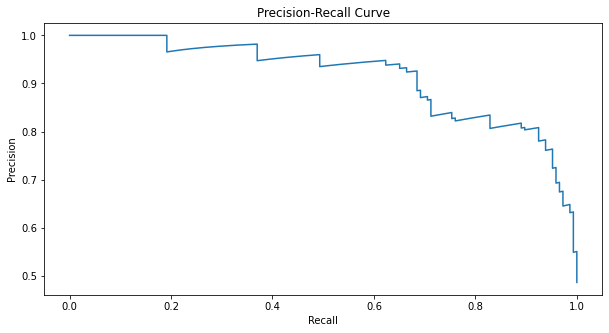

In [121]:
# precision-recall curveを描画
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(recall, precision)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')

In [123]:
recall[-1]

0.0

In [124]:
precision[-1]

1.0

In [126]:
print(len(recall))
print(len(precision))
print(len(thresholds))

210
210
209


recall,precisionの最後の値はそれぞれ0,1になっており、これらに対応するthresholdsは存在しないことに注意。

### ★Tips: JupyterLabからpip installをする場合は下記のようにセルに書いて実行
pip install --upgrade scikit-learn 　→scikit-learnをアップグレードする例 

## ○ F値
* sklearn.metrics.f1_score
    * f1_score(y_true, y_pred)
    * 他の指標同様にaverage引数で’macro’や’micro’など選択可能

In [133]:
# 心臓病の例のF値
f1_score(y_test, model.predict(X_test))

0.8469055374592833

.predictの予測値は閾値50%の値なので、上記で正しいのか？  
→多分全ての閾値ごとのrecall,precisionの値でF値を計算して最も大きい値を求める必要がある。

In [138]:
# 適当なデータのF値
y_true_tmp = [1, 0, 0, 1, 0, 0, 1, 1]
y_pred_tmp = [1, 1, 1, 0, 0, 1, 0, 1]
f1_score(y_true_tmp, y_pred_tmp)

0.4444444444444445

In [142]:
# 調和平均の検算.scipyのstatsモジュールを利用
hmean([recall_score(y_true_tmp, y_pred_tmp), precision_score(y_true_tmp, y_pred_tmp)])

0.4444444444444444

In [140]:
recall_score(y_true_tmp, y_pred_tmp)

0.5

In [141]:
precision_score(y_true_tmp, y_pred_tmp)

0.4

## ○ 閾値ごとのPrecision,Recall,F値の推移を描画

In [151]:
# thresholdごとのrecall,precisionからf値の配列を算出
f1 = hmean([recall, precision])

In [162]:
f1[:5]

array([0.65470852, 0.65765766, 0.66063348, 0.66213152, 0.66514806])

下記のようなzipとリスト内包表記を使った書き方もOK

In [167]:
#l = [hmean([r,p]) for r,p in zip(recall, precision)]
#l

89th thresholds=(0.44) is the highest f1 scores = 0.86


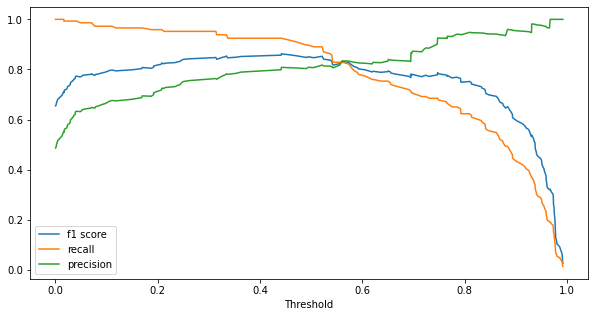

In [179]:
# それぞれの推移を描画
# thresholdsとprecision,recallの要素数は異なるのでスライシングで削る
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(thresholds, f1[:-1], label='f1 score')
ax.plot(thresholds, recall[:-1], label='recall')
ax.plot(thresholds, precision[:-1], label='precision')
ax.legend()
ax.set_xlabel('Threshold')
print(f'{np.argmax(f1)}th thresholds=({thresholds[np.argmax(f1)]:.2f}) is the highest f1 scores = {np.max(f1):.2f}')

In [171]:
# 最もF値が高いインデックスを調べる
np.argmax(f1)

89

In [180]:
thresholds[np.argmax(f1)]

0.4416469035360586

## ○ ROC 
* sklearn.metrics.roc_curve
    * roc_curve(y_true, y_score)
    * y_scoreには陽性の確率の値を入れれば良い
    * fpr(1-specificity), tpr, thresholdsの３つの一次元NumpyArrayを返す

In [185]:
# roc_curve関数を使う
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

Text(0.5, 1.0, 'ROC_curve')

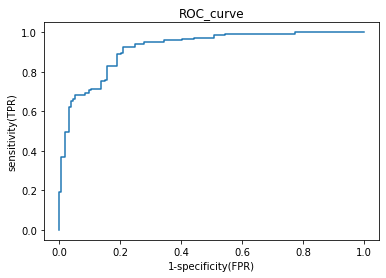

In [189]:
# 描画
plt.plot(fpr, tpr)
plt.xlabel('1-specificity(FPR)')
plt.ylabel('sensitivity(TPR)')
plt.title('ROC_curve')

In [191]:
thresholds[:5]

array([1.99179933, 0.99179933, 0.97781597, 0.97724868, 0.97670131])

最初は閾値が199%なので、すべて陰性と判定される。したがって、FPRもTPRも0。

## ○ AUC
* sklearn.metrics.auc
    * auc(fpr, tpr)
    * fprとtprはroc_curve関数の戻り値を使えば良い

In [199]:
# aucを算出
auc(fpr,tpr)

0.919542785981142

非常に精度が良いといえる。場合によっては過学習を疑うレベル。

## ○ 多クラスROCの描画
* 正解ラベルはone-hotの形にする
* macro平均を求めるにはそれぞれのクラス別のfpr, tprを求め，線形補完し平均を取る
* micro平均はone-hotの形の正解ラベルと予測した確率リストを一次元配列にしてroc_curve()に入れれば良い

In [286]:
# データ読み込み
df = sns.load_dataset('iris')
y_col = 'species'
X = df.drop(columns=[y_col])
y = df[y_col]

# hold-out
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# モデル学習。3クラスだが、デフォルトでmulti=autoなので何も指定しなくても多クラス分類してくれる。
model = LogisticRegression()
model.fit(X_train,y_train)

# 予測
y_pred_proba = model.predict_proba(X_test)

### ■ macro平均の場合

In [306]:
# 目的変数のエンコーディング
y_test_one_hot = label_binarize(y_test, classes=model.classes_)
print(model.classes_)
y_test_one_hot[:5]

['setosa' 'versicolor' 'virginica']


array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [307]:
print(y_test[:5])

114     virginica
62     versicolor
33         setosa
107     virginica
7          setosa
Name: species, dtype: object


エンコーディングされたことがわかる。

In [308]:
y_pred_proba[:5]

array([[1.31680402e-04, 5.98417206e-02, 9.40026599e-01],
       [1.33531075e-02, 9.57040110e-01, 2.96067823e-02],
       [9.82919663e-01, 1.70802808e-02, 5.56753076e-08],
       [1.60445709e-06, 2.60908819e-02, 9.73907514e-01],
       [9.68269781e-01, 3.17299834e-02, 2.35674717e-07]])

In [309]:
# それぞれのクラスのfpr,tpr,roc,aucを求める
n_classes = len(model.classes_)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    # それぞれのクラスごとにテストデータ、y_pred_probaを入れることに注意。thresholdsは今回使わないので捨てる
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(f'class:{i}')
    print(f'fpr: {fpr[i]}, tpr: {tpr[i]}')
    print(f'auc: {roc_auc[i]}\n')

class:0
fpr: [0. 0. 0. 1.], tpr: [0.     0.0625 1.     1.    ]
auc: 1.0

class:1
fpr: [0.         0.         0.         0.07407407 0.07407407 1.        ], tpr: [0.         0.05555556 0.94444444 0.94444444 1.         1.        ]
auc: 0.9958847736625515

class:2
fpr: [0.         0.         0.         0.02941176 0.02941176 1.        ], tpr: [0.         0.09090909 0.81818182 0.81818182 1.         1.        ]
auc: 0.9946524064171123



Text(0, 0.5, 'tpr')

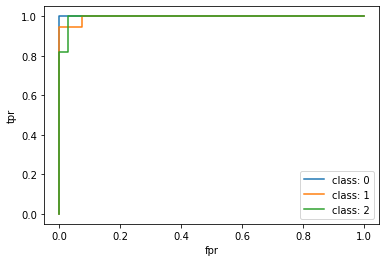

In [310]:
# それぞれのクラスのROC Curveを描画
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f'class: {i}')
    plt.legend()
    
plt.xlabel('fpr')
plt.ylabel('tpr')

macro平均のROCではclass:0～2のROCの平均を求める必要がある。  
class:0～2でyの値が異なるxにおける平均値を求めるイメージ。  
ただし、あるクラスにおけるxの値が他のクラスにおいてもあるとは限らない(scatterでプロットするとよくわかる)。  
これでは同じxにおけるyの平均値を求めることができないので、線形補間で存在しない値を補う必要がある。  

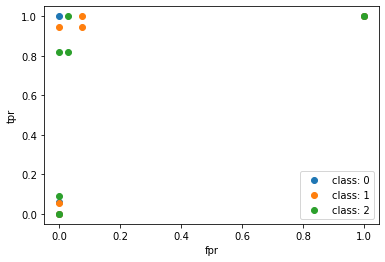

### ※ 線形補間
np.interp(x, xp, fp)　※補間：interpolation
* x: 補完後のx軸の値
* xp: xの値のリスト
* yp: yの値のリスト

In [311]:
# 線形補間で欲しいyに対するxの値を定義
all_x = np.arange(7)
# 補間に使う点（x,y）の値
data_x = [0, 2, 5, 6]
data_y = [0, 20, 40, 60]

# 線形補間でall_xに対するyの値を算出
np.interp(all_x, data_x, data_y)


array([ 0.        , 10.        , 20.        , 26.66666667, 33.33333333,
       40.        , 60.        ])

all_xに対してdata_x=1, 3 , 4に対するyの値がなかったが、線形補間によりそれらのxに対するyの値が補間されたことが分かる

### （続き）それぞれのクラスのROCについて線形補間を使って、平均のROCを求める

In [312]:
# 補間が必要なyに対するxの値のリスト。それぞれのクラスにない可能性のあるxを抽出するには、全クラスのfprのユニークな値を求めればよい。
# →リスト内包表記で全クラスのfprをリストにし、np.conatenateで結合して、.uniqueを使う。
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
all_fpr

array([0.        , 0.02941176, 0.07407407, 1.        ])

In [313]:
# 線形補間

# 最終的に補間されたtprの値(yの値)の3クラス平均を求める必要があるので、all_fprと同じ形の0配列を用意しておく。
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    # 線形補間した結果のtprを各クラスの要素ごとに足す
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# tprの平均値算出
mean_tpr = mean_tpr / n_classes

In [314]:
mean_tpr

array([0.92087542, 0.98148148, 1.        , 1.        ])

In [315]:
# all_fprに対応したtprの値が返ってくる。これを上記では各クラスの要素ごとに足している。
np.interp(all_fpr, fpr[1], tpr[1])

array([0.94444444, 0.94444444, 1.        , 1.        ])

In [316]:
# 平均の結果のfpr,tpr,aucをそれぞれ格納
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

In [317]:
fpr

{0: array([0., 0., 0., 1.]),
 1: array([0.        , 0.        , 0.        , 0.07407407, 0.07407407,
        1.        ]),
 2: array([0.        , 0.        , 0.        , 0.02941176, 0.02941176,
        1.        ]),
 'macro': array([0.        , 0.02941176, 0.07407407, 1.        ])}

Text(0, 0.5, 'tpr')

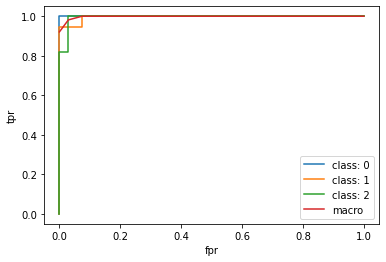

In [318]:
# macro平均のROC曲線を描画
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f'class: {i}')

plt.plot(fpr['macro'], tpr['macro'], label = 'macro')
plt.legend()    
plt.xlabel('fpr')
plt.ylabel('tpr')

### ■ micro平均の場合

In [319]:
# ROC_curveを適用するには、y_test_one_hotをまとめて1次元にする必要がある
y_test_one_hot[:5]

array([[0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [320]:
# .ravel()を使うと各クラスをまとめて1次元にしてくれる
y_test_one_hot.ravel()

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0])

In [321]:
# y_pred_probaも同様
y_pred_proba.ravel()[:6]

array([1.31680402e-04, 5.98417206e-02, 9.40026599e-01, 1.33531075e-02,
       9.57040110e-01, 2.96067823e-02])

In [322]:
# micro平均でのfpr,tpr,aucを取得
fpr['micro'], tpr['micro'], _ = roc_curve(y_test_one_hot.ravel(), y_pred_proba.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [324]:
fpr

{0: array([0., 0., 0., 1.]),
 1: array([0.        , 0.        , 0.        , 0.07407407, 0.07407407,
        1.        ]),
 2: array([0.        , 0.        , 0.        , 0.02941176, 0.02941176,
        1.        ]),
 'macro': array([0.        , 0.02941176, 0.07407407, 1.        ]),
 'micro': array([0.        , 0.        , 0.        , 0.01111111, 0.01111111,
        0.04444444, 0.04444444, 1.        ])}

Text(0, 0.5, 'tpr')

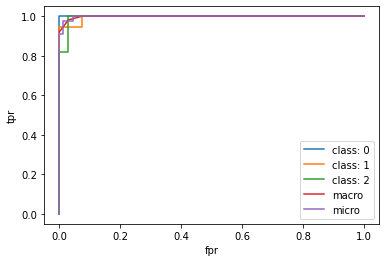

In [325]:
# macro平均とmicro平均のROC曲線を描画
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label = f'class: {i}')

plt.plot(fpr['macro'], tpr['macro'], label = 'macro')
plt.plot(fpr['micro'], tpr['micro'], label = 'micro')
plt.legend()    
plt.xlabel('fpr')
plt.ylabel('tpr')

macro平均は線形補間しているので比較的なめらかになるが、micro平均はそうではないのでかくかく。